import pandas as pd
import random

breeds_sizes = [
    ("Labrador Retriever", "large"),
    ("Golden Retriever", "large"),
    ("German Shepherd", "large"),
    ("Rottweiler", "large"),
    ("Great Dane", "large"),
    ("Doberman Pinscher", "large"),
    ("Siberian Husky", "medium"),
    ("Bulldog", "medium"),
    ("Boxer", "medium"),
    ("Australian Shepherd", "medium"),
    ("Border Collie", "medium"),
    ("Beagle", "small"),
    ("Dachshund", "small"),
    ("Poodle", "small"),
    ("Chihuahua", "small"),
    ("French Bulldog", "small"),
    ("Yorkshire Terrier", "small"),
    ("Shih Tzu", "small"),
    ("Maltese", "small"),
    ("Pomeranian", "small")
]

genders = ["Male", "Female"]

num_rows = 200

username_list = random.sample(range(1000, 10000), num_rows)

data = {
    "username": [],
    "pet_breed": [],
    "age": [],
    "size": [],
    "gender": [],
    "latitude": [],
    "longitude": []
}

for i in range(num_rows):
    # Pick a random breed-size pair
    breed, size = random.choice(breeds_sizes)
    
    # Random age between 1 and 15
    age = random.randint(1, 15)
    
    # Random gender
    gender = random.choice(genders)
    
    # Random geographic coordinates in Egypt
    lat = random.uniform(22.0, 31.0)
    lon = random.uniform(25.0, 36.0)
    
    data["username"].append(username_list[i])
    data["pet_breed"].append(breed)
    data["age"].append(age)
    data["size"].append(size)
    data["gender"].append(gender)
    data["latitude"].append(lat)
    data["longitude"].append(lon)

df = pd.DataFrame(data)

df.to_csv("datasetTest.csv", index=False)

# Show a small sample of the generated data
print("A dataset with 5,000 rows (all located in Egypt) has been generated and saved to 'clean_pet_dataset_5000.csv'.")
print(df.head(10))


In [156]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('datasetTest.csv')  # Adjust filename/path if needed

# Peek at the data
print(df.head())
print(df.info())
print(df.describe())


   username            pet_breed  age    size  gender   latitude  longitude
0      3253      German Shepherd   12   large    Male  25.982840  31.894171
1      9258  Australian Shepherd    7  medium    Male  23.288012  32.897613
2      5592       French Bulldog   14   small    Male  25.545165  31.327658
3      6728      German Shepherd   12   large  Female  26.419402  28.863693
4      9089       Siberian Husky   15  medium    Male  25.983587  32.708617
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   username   200 non-null    int64  
 1   pet_breed  200 non-null    object 
 2   age        200 non-null    int64  
 3   size       200 non-null    object 
 4   gender     200 non-null    object 
 5   latitude   200 non-null    float64
 6   longitude  200 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.1+ KB
None
         use

In [157]:
df_original = pd.read_csv('petProfiles.csv')

# Keep a copy of the original
df_for_model = df_original.copy()

# Drop or encode columns in df_for_model, but do NOT change the row order
df_for_model.drop(columns=['username'], inplace=True)

In [158]:
# Numerical columns we want to normalize
numerical_cols = ['age', 'latitude', 'longitude']

# Fill missing
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Use StandardScaler for normalization
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [159]:
categorical_cols = ['pet_breed', 'size', 'gender']
df = pd.get_dummies(df, columns=categorical_cols)


In [160]:
usernames = df['username'].copy()  # Series of user names/IDs

if 'username' in df.columns:
    df.drop(columns=['username'], inplace=True)

# Cast entire DataFrame to float32
df = df.astype('float32')

# Convert to NumPy array
pet_features = df.values  # shape: (num_pets, num_features)
print("pet_features dtype:", pet_features.dtype)  # should be float32
print("pet_features shape:", pet_features.shape)


pet_features dtype: float32
pet_features shape: (200, 28)


In [161]:
all_columns = list(df.columns)

breed_cols = [c for c in all_columns if c.startswith('pet_breed_')]
size_cols  = [c for c in all_columns if c.startswith('size_')]
gender_cols = [c for c in all_columns if c.startswith('gender_')]

# 'age' is numeric, now normalized. We'll find its index:
age_index = all_columns.index('age')


In [162]:
def same_one_hot(vecA, vecB, indices):
    """Check if vecA and vecB match exactly for all columns in 'indices'."""
    return np.allclose(vecA[indices], vecB[indices])  # or (vecA[indices] == vecB[indices]) for ints

def age_similar(vecA, vecB, idx_age, max_diff=0.2):
    """
    Because 'age' is normalized, a difference of 0.2 might correspond to ~2 years in original scale,
    depending on how StandardScaler transformed your data.
    Adjust 'max_diff' as needed.
    """
    return abs(vecA[idx_age] - vecB[idx_age]) <= max_diff


In [163]:
pairs = []
labels = []

num_pets = pet_features.shape[0]

# Convert our breed_cols, size_cols, gender_cols to indices
breed_indices  = [all_columns.index(c) for c in breed_cols]
size_indices   = [all_columns.index(c) for c in size_cols]
gender_indices = [all_columns.index(c) for c in gender_cols]

for i in range(num_pets - 1):
    for j in range(i + 1, num_pets):
        petA = pet_features[i]
        petB = pet_features[j]
        pairs.append([petA, petB])
        
        # Evaluate similarity
        has_same_breed  = same_one_hot(petA, petB, breed_indices)
        has_same_size   = same_one_hot(petA, petB, size_indices)
        has_same_gender = same_one_hot(petA, petB, gender_indices)
        is_age_close    = age_similar(petA, petB, age_index, max_diff=0.2)
        
        # If all match, label = 1, else 0
        label = 1 if (has_same_breed and has_same_size and has_same_gender and is_age_close) else 0
        labels.append(label)

pairs = np.array(pairs, dtype='float32')
labels = np.array(labels, dtype='float32')

print("Pairs shape:", pairs.shape, "Labels shape:", labels.shape)


Pairs shape: (19900, 2, 28) Labels shape: (19900,)


In [164]:
pet_features_1 = pairs[:, 0]
pet_features_2 = pairs[:, 1]


In [ ]:
def create_subnetwork(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(32, activation='relu')(x)
    # Final embedding dimension (e.g., 16)
    x = layers.Dense(16, activation='relu')(x)
    return models.Model(inp, x)

input_shape = (pet_features_1.shape[1],)  # e.g. (num_features,)
pet_network = create_subnetwork(input_shape)


In [ ]:
input_pet1 = Input(shape=input_shape, name='pet1_input')
input_pet2 = Input(shape=input_shape, name='pet2_input')

embedding_pet1 = pet_network(input_pet1)
embedding_pet2 = pet_network(input_pet2)

def euclidean_distance(vectors):
    petA, petB = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(petA - petB), axis=1, keepdims=True))

distance = layers.Lambda(euclidean_distance, name='distance')([embedding_pet1, embedding_pet2])

model = models.Model([input_pet1, input_pet2], distance)
model.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pet1_input (InputLayer)        [(None, 28)]         0           []                               
                                                                                                  
 pet2_input (InputLayer)        [(None, 28)]         0           []                               
                                                                                                  
 model_18 (Functional)          (None, 16)           4464        ['pet1_input[0][0]',             
                                                                  'pet2_input[0][0]']             
                                                                                                  
 distance (Lambda)              (None, 1)            0           ['model_18[0][0]',        

In [ ]:
def contrastive_loss(y_true, y_pred):
    # Cast to float32 if needed
    y_true = tf.cast(y_true, tf.float32)
    margin = 1.0
    # y_true=1 => similar => distance^2
    # y_true=0 => dissimilar => (max(margin-distance, 0))^2
    return K.mean(
        y_true * K.square(y_pred) + 
        (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))
    )

model.compile(optimizer='adam', loss=contrastive_loss)


In [ ]:
X_train1, X_val1, X_train2, X_val2, y_train, y_val = train_test_split(
    pet_features_1, pet_features_2, labels,
    test_size=0.2, random_state=42
)

# Ensure all are float32
X_train1 = X_train1.astype('float32')
X_train2 = X_train2.astype('float32')
X_val1   = X_val1.astype('float32')
X_val2   = X_val2.astype('float32')
y_train  = y_train.astype('float32')
y_val    = y_val.astype('float32')

history = model.fit(
    [X_train1, X_train2], y_train,
    validation_data=([X_val1, X_val2], y_val),
    epochs=10, batch_size=32
)


Epoch 1/10
498/498 [==============================] - 6s 10ms/step - loss: 0.0118 - val_loss: 0.0022
Epoch 2/10
498/498 [==============================] - 4s 8ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/10
498/498 [==============================] - 4s 9ms/step - loss: 9.3587e-04 - val_loss: 8.8300e-04
Epoch 4/10
498/498 [==============================] - 5s 10ms/step - loss: 6.0059e-04 - val_loss: 7.9558e-04
Epoch 5/10
498/498 [==============================] - 5s 10ms/step - loss: 4.7056e-04 - val_loss: 5.8444e-04
Epoch 6/10
498/498 [==============================] - 3s 7ms/step - loss: 4.7995e-04 - val_loss: 7.3901e-04
Epoch 7/10
498/498 [==============================] - 4s 8ms/step - loss: 4.6495e-04 - val_loss: 5.1724e-04
Epoch 8/10
498/498 [==============================] - 5s 10ms/step - loss: 3.1156e-04 - val_loss: 5.0610e-04
Epoch 9/10
498/498 [==============================] - 3s 7ms/step - loss: 3.7105e-04 - val_loss: 3.9750e-04
Epoch 10/10
498/498 [===================

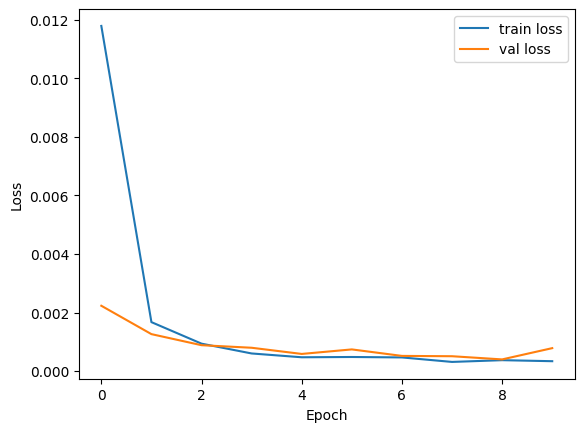

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The matched users

In [ ]:
# All embeddings
all_pet_embeddings = pet_network.predict(pet_features)

# Example: pick the first pet
new_pet = pet_features[0].reshape(1, -1)
new_pet_embedding = pet_network.predict(new_pet)

# Distances
distances = np.linalg.norm(all_pet_embeddings - new_pet_embedding, axis=1)

# Sort by ascending distance
top_k = 5
closest_indices = np.argsort(distances)[:top_k]
print("Top matching pet indices for the selected pet:", closest_indices)


1/1 [==============================] - 0s 16ms/step
Top matching pet indices for the selected pet: [  0  89   3 144 146]


In [ ]:
import numpy as np

# Suppose you have your final 'all_pet_embeddings' for the entire dataset
# and you pick a query index (e.g., 0) to find a match for
query_idx = 0
query_embedding = pet_network.predict(pet_features[query_idx].reshape(1, -1))

# Compute distances to all embeddings
distances = np.linalg.norm(all_pet_embeddings - query_embedding, axis=1)

# Optionally set the query's own distance to infinity so it doesn't match itself
distances[query_idx] = np.inf

# Get index of best match
best_match_idx = np.argmin(distances)

# Now retrieve the username from your separate structure
query_username = usernames.iloc[query_idx]
matched_username = usernames.iloc[best_match_idx]

print("Query User:", query_username, "was matched with:", matched_username)


1/1 [==============================] - 0s 19ms/step
Query User: 3253 was matched with: 8237


In [ ]:
top_5_idx = np.argsort(distances)[:5]
top_5_usernames = usernames.iloc[top_5_idx]
print("Query user:", query_username, "Top matches:", list(top_5_usernames))


Query user: 3253 Top matches: [8237, 6728, 9628, 2076, 4909]


In [ ]:
# best_match_idx is the row index from the model's perspective
print("Username:", usernames.iloc[best_match_idx])

# Then show the numeric/one-hot columns from df
print(df.iloc[best_match_idx])


Username: 8237
age                              0.709255
latitude                        -0.921739
longitude                        1.124399
pet_breed_Australian Shepherd    0.000000
pet_breed_Beagle                 0.000000
pet_breed_Border Collie          1.000000
pet_breed_Boxer                  0.000000
pet_breed_Bulldog                0.000000
pet_breed_Chihuahua              0.000000
pet_breed_Dachshund              0.000000
pet_breed_Doberman Pinscher      0.000000
pet_breed_French Bulldog         0.000000
pet_breed_German Shepherd        0.000000
pet_breed_Golden Retriever       0.000000
pet_breed_Great Dane             0.000000
pet_breed_Labrador Retriever     0.000000
pet_breed_Maltese                0.000000
pet_breed_Pomeranian             0.000000
pet_breed_Poodle                 0.000000
pet_breed_Rottweiler             0.000000
pet_breed_Shih Tzu               0.000000
pet_breed_Siberian Husky         0.000000
pet_breed_Yorkshire Terrier      0.000000
size_large         

In [ ]:
import numpy as np

# 1. Suppose you've already loaded df_original (the text-based DataFrame)
#    and df_for_model (the numeric DataFrame used for training).

#    We'll assume df_for_model has been converted to a NumPy array called `pet_features`.
#    We also assume you have a trained subnetwork pet_network that outputs embeddings.

# 2. Compute embeddings for ALL rows in df_for_model
all_pet_embeddings = pet_network.predict(pet_features)  # shape: (N, embed_dim)

# 3. Choose a query user by row index in df_original
#    For example, let's pick user #0, or search by username if you have a reference
query_idx = 0

# 4. Display the query user's details
print("=== Query User Details ===")
print(df_original.iloc[query_idx])  # Full textual info, including username, breed, etc.

# 5. Embed the query user using the subnetwork
query_vector = pet_features[query_idx].reshape(1, -1)
query_embedding = pet_network.predict(query_vector)  # shape: (1, embed_dim)

# 6. Compute distances from the query user to all users
distances = np.linalg.norm(all_pet_embeddings - query_embedding, axis=1)

# Optional: set the query user’s own distance to infinity if you don’t want them matched to themselves
distances[query_idx] = np.inf

# 7. Find the top K matches by ascending distance
top_k = 5
closest_indices = np.argsort(distances)[:top_k]

# 8. Print the matched users' details
print(f"\n=== Top {top_k} Matched Users for Query User Index {query_idx} ===")
for rank, match_idx in enumerate(closest_indices, start=1):
    print(f"\nMatch #{rank} at index {match_idx}, distance={distances[match_idx]:.4f}")
    print(df_original.iloc[match_idx])  # Full details (username, breed, age, etc.)


7/7 [==============================] - 0s 2ms/step
=== Query User Details ===
username          4860
pet_breed       Beagle
age                  5
size             small
gender          Female
latitude      27.30059
longitude    33.071099
Name: 0, dtype: object
1/1 [==============================] - 0s 47ms/step

=== Top 5 Matched Users for Query User Index 0 ===

Match #1 at index 89, distance=1.1193
username          5899
pet_breed    Chihuahua
age                  7
size             small
gender            Male
latitude     28.396488
longitude    33.121504
Name: 89, dtype: object

Match #2 at index 3, distance=1.3330
username          8600
pet_breed    Dachshund
age                 13
size             small
gender            Male
latitude      29.85926
longitude    35.052661
Name: 3, dtype: object

Match #3 at index 144, distance=1.3618
username           5461
pet_breed    Great Dane
age                  15
size              large
gender           Female
latitude      23.955829
long